In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta  # For technical indicators
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import optuna  # For hyperparameter tuning


In [2]:
# Download historical data for AAPL
stock_data = yf.download('AAPL', start='2010-01-01')

# Display the first few rows
stock_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461976,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473149,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370185,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358408,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400682,447610800


In [3]:
# Technical Indicators
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close'], window=14).rsi()
stock_data['MACD'] = ta.trend.MACD(stock_data['Close']).macd()
stock_data['Bollinger_High'] = ta.volatility.BollingerBands(stock_data['Close']).bollinger_hband()
stock_data['Bollinger_Low'] = ta.volatility.BollingerBands(stock_data['Close']).bollinger_lband()

# Lagged Features
stock_data['Lag_1'] = stock_data['Close'].shift(1)
stock_data['Lag_2'] = stock_data['Close'].shift(2)

# Drop NaN values
stock_data = stock_data.dropna()

# Target variable
y = stock_data['Close'].shift(-1)  # Predict next day's price

# Drop the last row as it will have NaN target
stock_data = stock_data.iloc[:-1]
y = y.iloc[:-1]

# Define features
X = stock_data[['SMA_20', 'SMA_50', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'Lag_1', 'Lag_2']]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Random Forest Regressor

In [4]:
# Define the Random Forest model pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning with RandomizedSearchCV
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search
rf_search = RandomizedSearchCV(rf_pipeline, param_distributions=param_grid_rf, n_iter=10, cv=tscv, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Best model
best_rf_model = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.4f}")


Random Forest MSE: 695.2609


### XG Boost

In [5]:
# Define XGBoost model pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter tuning
param_grid_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Randomized search
xgb_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_grid_xgb, n_iter=10, cv=tscv, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)

# Best model
best_xgb_model = xgb_search.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.4f}")


XGBoost MSE: 857.9587


### LSTM Neural Network

In [6]:
# Reshape data for LSTM (3D input: [samples, timesteps, features])
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate model
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM MSE: {mse_lstm:.4f}")


Epoch 1/20
91/91 [==============================] - ETA: 12:56 - loss: 3286.748 - ETA: 4s - loss: 2949.7670  - ETA: 2s - loss: 2858.81 - ETA: 1s - loss: 2861.32 - ETA: 1s - loss: 2863.98 - ETA: 1s - loss: 2884.42 - ETA: 1s - loss: 2908.73 - ETA: 1s - loss: 2909.88 - ETA: 1s - loss: 2901.31 - ETA: 0s - loss: 2886.51 - ETA: 0s - loss: 2879.51 - ETA: 0s - loss: 2868.79 - ETA: 0s - loss: 2853.61 - ETA: 0s - loss: 2832.40 - ETA: 0s - loss: 2817.32 - ETA: 0s - loss: 2798.49 - ETA: 0s - loss: 2778.27 - ETA: 0s - loss: 2760.91 - ETA: 0s - loss: 2733.00 - ETA: 0s - loss: 2722.11 - ETA: 0s - loss: 2681.19 - ETA: 0s - loss: 2633.39 - 10s 15ms/step - loss: 2591.5492
Epoch 2/20
91/91 [==============================] - ETA: 1s - loss: 983.073 - ETA: 1s - loss: 1039.74 - ETA: 1s - loss: 1060.10 - ETA: 1s - loss: 1038.97 - ETA: 1s - loss: 1017.91 - ETA: 1s - loss: 1008.86 - ETA: 1s - loss: 993.8521 - ETA: 1s - loss: 975.719 - ETA: 1s - loss: 958.948 - ETA: 1s - loss: 949.778 - ETA: 1s - loss: 937.888 

91/91 [==============================] - ETA: 0s - loss: 57.82 - ETA: 0s - loss: 50.39 - ETA: 0s - loss: 53.27 - ETA: 0s - loss: 53.94 - ETA: 0s - loss: 53.08 - ETA: 0s - loss: 52.61 - ETA: 0s - loss: 51.88 - ETA: 0s - loss: 51.18 - ETA: 0s - loss: 50.43 - ETA: 0s - loss: 49.99 - ETA: 0s - loss: 49.72 - ETA: 0s - loss: 49.50 - ETA: 0s - loss: 49.31 - 1s 8ms/step - loss: 49.2611
Epoch 20/20
91/91 [==============================] - ETA: 0s - loss: 63.99 - ETA: 0s - loss: 57.26 - ETA: 0s - loss: 56.20 - ETA: 0s - loss: 55.40 - ETA: 0s - loss: 54.33 - ETA: 0s - loss: 53.65 - ETA: 0s - loss: 53.20 - ETA: 0s - loss: 52.80 - ETA: 0s - loss: 52.63 - ETA: 0s - loss: 52.44 - ETA: 0s - loss: 52.30 - ETA: 0s - loss: 52.13 - ETA: 0s - loss: 51.97 - ETA: 0s - loss: 51.81 - ETA: 0s - loss: 51.66 - ETA: 0s - loss: 51.53 - ETA: 0s - loss: 51.40 - ETA: 0s - loss: 51.28 - ETA: 0s - loss: 51.22 - ETA: 0s - loss: 51.15 - 1s 12ms/step - loss: 51.1053
LSTM MSE: 1552.8779


In [7]:
# Ensemble prediction (average of all models)
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lstm.flatten()) / 3

# Evaluate ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print(f"Ensemble Model MSE: {mse_ensemble:.4f}")


Ensemble Model MSE: 984.2457


### Generating buy/sell signals

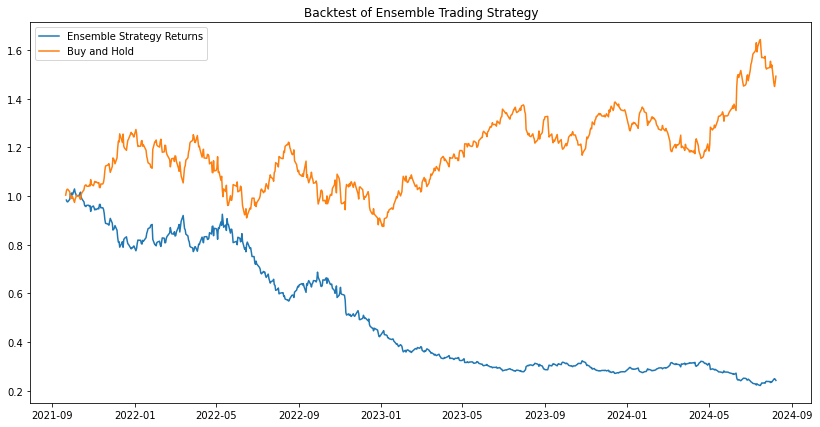

In [8]:
# Create buy/sell signals based on ensemble predictions
signals = pd.DataFrame(index=stock_data.index[-len(y_test):])
signals['Actual'] = y_test
signals['Predicted'] = y_pred_ensemble

# Signal generation (buy if tomorrow's price is expected to be higher, sell if lower)
signals['Signal'] = np.where(signals['Predicted'] > signals['Actual'], 1, -1)

# Calculate strategy returns
signals['Strategy_Return'] = signals['Signal'].shift(1) * stock_data['Close'].pct_change()[-len(y_test):]
signals['Cumulative_Return'] = (1 + signals['Strategy_Return']).cumprod()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(signals['Cumulative_Return'], label='Ensemble Strategy Returns')
plt.plot((1 + stock_data['Close'].pct_change()[-len(y_test):]).cumprod(), label='Buy and Hold')
plt.title('Backtest of Ensemble Trading Strategy')
plt.legend()
plt.show()


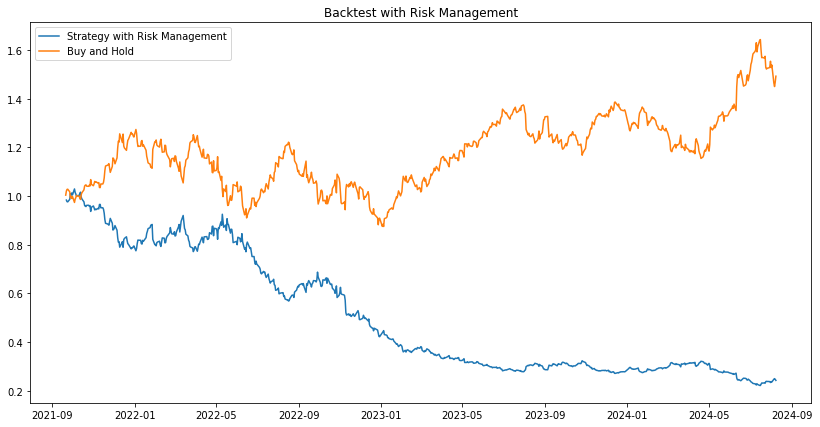

In [9]:
# Implement stop-loss and take-profit
stop_loss_pct = 0.02
take_profit_pct = 0.05

signals['Stop_Loss'] = signals['Actual'] * (1 - stop_loss_pct)
signals['Take_Profit'] = signals['Actual'] * (1 + take_profit_pct)

signals['Strategy_Return'] = np.where(signals['Predicted'] > signals['Actual'],
                                      np.where(stock_data['Close'][-len(y_test):] < signals['Stop_Loss'], -stop_loss_pct,
                                               np.where(stock_data['Close'][-len(y_test):] > signals['Take_Profit'], take_profit_pct,
                                                        signals['Strategy_Return'])),
                                      signals['Strategy_Return'])

signals['Cumulative_Return'] = (1 + signals['Strategy_Return']).cumprod()

# Plot the results with risk management
plt.figure(figsize=(14, 7))
plt.plot(signals['Cumulative_Return'], label='Strategy with Risk Management')
plt.plot((1 + stock_data['Close'].pct_change()[-len(y_test):]).cumprod(), label='Buy and Hold')
plt.title('Backtest with Risk Management')
plt.legend()
plt.show()


In [10]:
# Calculate Sharpe Ratio
sharpe_ratio = signals['Strategy_Return'].mean() / signals['Strategy_Return'].std() * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Calculate maximum drawdown
drawdown = signals['Cumulative_Return'].div(signals['Cumulative_Return'].cummax()).sub(1)
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.4f}")


Sharpe Ratio: -1.6412
Maximum Drawdown: -0.7851


[*********************100%%**********************]  1 of 1 completed


Simplified Sharpe Ratio: -0.6214
Simplified Maximum Drawdown: -0.6141


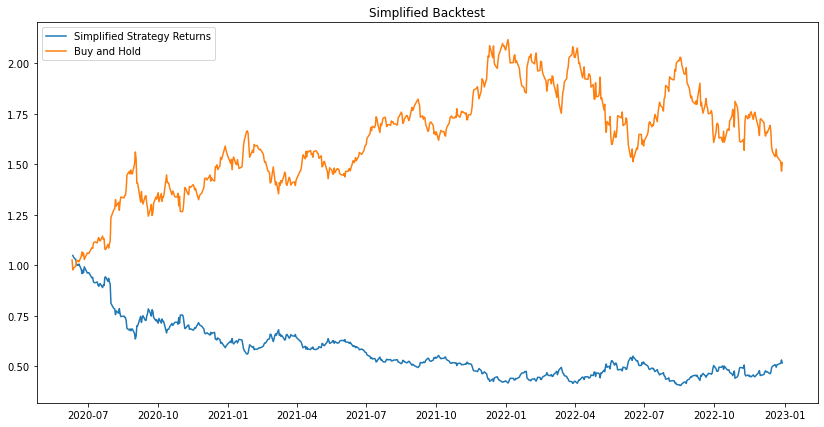

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Download Historical Data
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')

# Feature Engineering (Simplified)
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Target variable
y = stock_data['Close'].shift(-1)
stock_data = stock_data.iloc[:-1]
y = y.iloc[:-1]

# Simplified feature set
X = stock_data[['SMA_20', 'SMA_50', 'Daily_Return']]

# Remove NaN values
X = X.dropna()
y = y.loc[X.index]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Signal generation
signals = pd.DataFrame(index=X_test.index)
signals['Actual'] = y_test
signals['Predicted'] = y_pred_rf
signals['Signal'] = np.where(signals['Predicted'] > signals['Actual'], 1, -1)

# Strategy Return
signals['Strategy_Return'] = signals['Signal'].shift(1) * stock_data['Close'].pct_change()[-len(y_test):]
signals['Cumulative_Return'] = (1 + signals['Strategy_Return']).cumprod()

# Evaluate
sharpe_ratio = signals['Strategy_Return'].mean() / signals['Strategy_Return'].std() * np.sqrt(252)
drawdown = signals['Cumulative_Return'].div(signals['Cumulative_Return'].cummax()).sub(1)
max_drawdown = drawdown.min()

print(f"Simplified Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Simplified Maximum Drawdown: {max_drawdown:.4f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(signals['Cumulative_Return'], label='Simplified Strategy Returns')
plt.plot((1 + stock_data['Close'].pct_change()[-len(y_test):]).cumprod(), label='Buy and Hold')
plt.title('Simplified Backtest')
plt.legend()
plt.show()
